In [1]:
import torch
import torch.nn as nn
from strokes import StrokePatientsMIDataset, StrokePatientsMIProcessedDataset
from strokesdict import STROKEPATIENTSMI_LOCATION_DICT
from torcheeg.transforms import Select,BandSignal,Compose
from to import ToGrid, ToTensor
from downsample import SetSamplingRate
from baseline import BaselineCorrection

dataset = StrokePatientsMIDataset(root_path='./subdataset',
                                  io_path='.torcheeg/datasets_1746778836551_TWL41',
                        chunk_size=500,  # 1 second
                        overlap = 250,
                        offline_transform=Compose(
                                [BaselineCorrection(),
                                SetSamplingRate(origin_sampling_rate=500,target_sampling_rate=128),
                                BandSignal(sampling_rate=128,band_dict={'frequency_range':[8,40]})
                                ]),
                        online_transform=Compose(
                                [ToGrid(STROKEPATIENTSMI_LOCATION_DICT),ToTensor()]),
                        label_transform=Select('label'),
                        num_worker=8
)
print(dataset[0][0].shape) #EEG shape:torch.Size([1, 128, 9, 9])
print(dataset[0][1])  # label (int)
print(len(dataset))

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2025-05-09 16:56:32] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from .torcheeg/datasets_1746778836551_TWL41.


torch.Size([1, 128, 9, 9])
0
240


In [3]:
from eegswintransformer import SwinTransformer

HYPERPARAMETERS = {
    "seed": 42,
    "batch_size": 16,
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "num_epochs": 30,
}
from torcheeg.model_selection import KFoldPerSubjectGroupbyTrial
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import DataLoader
from classifier import ClassifierTrainer

k_fold = KFoldPerSubjectGroupbyTrial(
    n_splits=4,
    shuffle=True,
    # split_path='.torcheeg/model_selection_1741918660674_jp0WB',
    random_state=42)

training_metrics = []
test_metrics = []

for i, (training_dataset, test_dataset) in enumerate(k_fold.split(dataset)):
    model = SwinTransformer(patch_size=(8,1,1),
                            depths=(2, 2, 4),
                            num_heads=(2,2,3),
                            window_size=(4,3,3)
                            )
    trainer = ClassifierTrainer(model=model,
                                num_classes=2,
                                lr=HYPERPARAMETERS['lr'],
                                weight_decay=HYPERPARAMETERS['weight_decay'],
                                metrics=["accuracy"],
                                accelerator="gpu")
    training_loader = DataLoader(training_dataset,
                             batch_size=HYPERPARAMETERS['batch_size'],
                             shuffle=True)
    test_loader = DataLoader(test_dataset,
                             batch_size=HYPERPARAMETERS['batch_size'],
                             shuffle=False)
    # 提前停止回调
    early_stopping_callback = EarlyStopping(
        monitor='train_loss',
        patience=50,
        mode='min',
        verbose=True
    )
    trainer.fit(training_loader,
                test_loader,
                max_epochs=HYPERPARAMETERS['num_epochs'],
                callbacks=[early_stopping_callback],
                # enable_progress_bar=True,
                enable_model_summary=False,
                limit_val_batches=0.0)
    training_result = trainer.test(training_loader,
                                   enable_progress_bar=True,
                                   enable_model_summary=True)[0]
    test_result = trainer.test(test_loader,
                               enable_progress_bar=True,
                               enable_model_summary=True)[0]
    training_metrics.append(training_result["test_accuracy"])
    test_metrics.append(test_result["test_accuracy"])
    
    
    # ✅ 保存模型参数
    model_path = f"swin_fold_{i+1}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"✅ 模型参数已保存到 {model_path}")

    
     

[2025-05-09 16:21:30] INFO (torcheeg/MainThread) 📊 | Create the split of train and test set.
[2025-05-09 16:21:30] INFO (torcheeg/MainThread) 😊 | Please set split_path to .torcheeg/model_selection_1746778890911_wcZa3 for the next run, if you want to use the same setting for the experiment.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 16.27it/s, loss=3.16, train_loss=0.915, train_accuracy=0.750]

Metric train_loss improved. New best score: 0.915


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 16.23it/s, loss=3.16, train_loss=0.915, train_accuracy=0.750]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-05-09 16:21:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 3.164 train_accuracy: 0.519 



Epoch 1: 100%|██████████| 10/10 [00:00<00:00, 16.71it/s, loss=2, train_loss=0.681, train_accuracy=0.562]   

Metric train_loss improved by 0.234 >= min_delta = 0.0. New best score: 0.681


Epoch 1: 100%|██████████| 10/10 [00:00<00:00, 16.67it/s, loss=2, train_loss=0.681, train_accuracy=0.562]

[2025-05-09 16:21:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.836 train_accuracy: 0.556 



Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 16.48it/s, loss=0.831, train_loss=0.771, train_accuracy=0.438]

[2025-05-09 16:21:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.826 train_accuracy: 0.544 



Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 16.76it/s, loss=0.761, train_loss=0.678, train_accuracy=0.625]

Metric train_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.678


Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 16.70it/s, loss=0.761, train_loss=0.678, train_accuracy=0.625]

[2025-05-09 16:21:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.697 train_accuracy: 0.544 



Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 16.36it/s, loss=0.701, train_loss=0.627, train_accuracy=0.625]

Metric train_loss improved by 0.051 >= min_delta = 0.0. New best score: 0.627


Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 16.30it/s, loss=0.701, train_loss=0.627, train_accuracy=0.625]

[2025-05-09 16:21:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.706 train_accuracy: 0.531 



Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 15.96it/s, loss=0.728, train_loss=0.715, train_accuracy=0.438]

[2025-05-09 16:21:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.750 train_accuracy: 0.506 



Epoch 6: 100%|██████████| 10/10 [00:00<00:00, 16.00it/s, loss=0.7, train_loss=0.493, train_accuracy=0.875]  

Metric train_loss improved by 0.133 >= min_delta = 0.0. New best score: 0.493


Epoch 6: 100%|██████████| 10/10 [00:00<00:00, 15.95it/s, loss=0.7, train_loss=0.493, train_accuracy=0.875]

[2025-05-09 16:21:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.649 train_accuracy: 0.606 



Epoch 7: 100%|██████████| 10/10 [00:00<00:00, 16.37it/s, loss=0.611, train_loss=0.455, train_accuracy=0.750]

Metric train_loss improved by 0.038 >= min_delta = 0.0. New best score: 0.455


Epoch 7: 100%|██████████| 10/10 [00:00<00:00, 16.32it/s, loss=0.611, train_loss=0.455, train_accuracy=0.750]

[2025-05-09 16:21:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.574 train_accuracy: 0.650 



Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 16.69it/s, loss=0.527, train_loss=0.470, train_accuracy=0.750]

[2025-05-09 16:21:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.481 train_accuracy: 0.731 



Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 16.79it/s, loss=0.333, train_loss=0.156, train_accuracy=0.938]

Metric train_loss improved by 0.300 >= min_delta = 0.0. New best score: 0.156


Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 16.74it/s, loss=0.333, train_loss=0.156, train_accuracy=0.938]

[2025-05-09 16:21:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.186 train_accuracy: 0.956 



Epoch 10: 100%|██████████| 10/10 [00:00<00:00, 16.83it/s, loss=0.117, train_loss=0.102, train_accuracy=0.938]  

Metric train_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.102


Epoch 10: 100%|██████████| 10/10 [00:00<00:00, 16.78it/s, loss=0.117, train_loss=0.102, train_accuracy=0.938]

[2025-05-09 16:21:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.048 train_accuracy: 0.981 



Epoch 11: 100%|██████████| 10/10 [00:00<00:00, 16.77it/s, loss=0.0436, train_loss=0.0148, train_accuracy=1.000] 

Metric train_loss improved by 0.088 >= min_delta = 0.0. New best score: 0.015


Epoch 11: 100%|██████████| 10/10 [00:00<00:00, 16.71it/s, loss=0.0436, train_loss=0.0148, train_accuracy=1.000]

[2025-05-09 16:21:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.040 train_accuracy: 0.988 



Epoch 12: 100%|██████████| 10/10 [00:00<00:00, 16.64it/s, loss=0.0451, train_loss=0.0225, train_accuracy=1.000]

[2025-05-09 16:21:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.051 train_accuracy: 0.981 



Epoch 13: 100%|██████████| 10/10 [00:00<00:00, 16.82it/s, loss=0.038, train_loss=0.00257, train_accuracy=1.000]

Metric train_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.003


Epoch 13: 100%|██████████| 10/10 [00:00<00:00, 16.78it/s, loss=0.038, train_loss=0.00257, train_accuracy=1.000]

[2025-05-09 16:21:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.025 train_accuracy: 0.988 



Epoch 14: 100%|██████████| 10/10 [00:00<00:00, 16.73it/s, loss=0.0279, train_loss=0.0185, train_accuracy=1.000]  

[2025-05-09 16:21:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.030 train_accuracy: 0.981 



Epoch 15: 100%|██████████| 10/10 [00:00<00:00, 16.70it/s, loss=0.0267, train_loss=0.00458, train_accuracy=1.000]

[2025-05-09 16:21:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.023 train_accuracy: 0.994 



Epoch 16: 100%|██████████| 10/10 [00:00<00:00, 16.75it/s, loss=0.0515, train_loss=0.196, train_accuracy=0.938]  

[2025-05-09 16:21:42] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.080 train_accuracy: 0.975 



Epoch 17: 100%|██████████| 10/10 [00:00<00:00, 16.91it/s, loss=0.0563, train_loss=0.0773, train_accuracy=0.938]

[2025-05-09 16:21:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.033 train_accuracy: 0.988 



Epoch 18: 100%|██████████| 10/10 [00:00<00:00, 16.95it/s, loss=0.0274, train_loss=0.0481, train_accuracy=1.000] 

[2025-05-09 16:21:43] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.022 train_accuracy: 0.994 



Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 16.99it/s, loss=0.0175, train_loss=0.000785, train_accuracy=1.000]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.001


Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 16.94it/s, loss=0.0175, train_loss=0.000785, train_accuracy=1.000]

[2025-05-09 16:21:44] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 0.994 



Epoch 20: 100%|██████████| 10/10 [00:00<00:00, 17.05it/s, loss=0.0134, train_loss=0.00023, train_accuracy=1.000] 

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 20: 100%|██████████| 10/10 [00:00<00:00, 17.00it/s, loss=0.0134, train_loss=0.00023, train_accuracy=1.000]

[2025-05-09 16:21:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.014 train_accuracy: 0.988 



Epoch 21: 100%|██████████| 10/10 [00:00<00:00, 17.04it/s, loss=0.012, train_loss=0.00304, train_accuracy=1.000] 

[2025-05-09 16:21:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.010 train_accuracy: 0.994 



Epoch 22: 100%|██████████| 10/10 [00:00<00:00, 16.94it/s, loss=0.00678, train_loss=0.00116, train_accuracy=1.000] 

[2025-05-09 16:21:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 10/10 [00:00<00:00, 16.51it/s, loss=0.00207, train_loss=0.000152, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 10/10 [00:00<00:00, 16.45it/s, loss=0.00207, train_loss=0.000152, train_accuracy=1.000]

[2025-05-09 16:21:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 10/10 [00:00<00:00, 16.63it/s, loss=0.00068, train_loss=0.00374, train_accuracy=1.000] 

[2025-05-09 16:21:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 10/10 [00:00<00:00, 16.72it/s, loss=0.000391, train_loss=3.84e-5, train_accuracy=1.000]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 10/10 [00:00<00:00, 16.67it/s, loss=0.000391, train_loss=3.84e-5, train_accuracy=1.000]

[2025-05-09 16:21:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 10/10 [00:00<00:00, 16.71it/s, loss=6.08e-05, train_loss=0.000446, train_accuracy=1.000]

[2025-05-09 16:21:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 10/10 [00:00<00:00, 16.68it/s, loss=7.74e-05, train_loss=0.000211, train_accuracy=1.000]

[2025-05-09 16:21:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 10/10 [00:00<00:00, 16.70it/s, loss=6.56e-05, train_loss=3.4e-5, train_accuracy=1.000]  

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 10/10 [00:00<00:00, 16.64it/s, loss=6.56e-05, train_loss=3.4e-5, train_accuracy=1.000]

[2025-05-09 16:21:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 10/10 [00:00<00:00, 16.72it/s, loss=4.97e-05, train_loss=6.88e-6, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 10/10 [00:00<00:00, 16.67it/s, loss=4.97e-05, train_loss=6.88e-6, train_accuracy=1.000]

[2025-05-09 16:21:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 10/10 [00:00<00:00, 16.58it/s, loss=4.97e-05, train_loss=6.88e-6, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 59.42it/s]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-05-09 16:21:51] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 57.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss         1.5401865312014706e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 60.05it/s]

[2025-05-09 16:21:52] INFO (torcheeg/MainThread) 
[Test] test_loss: 2.417 test_accuracy: 0.725 



Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 57.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.7250000238418579
        test_loss            2.416637420654297
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
✅ 模型参数已保存到 swin_fold_1.pth


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 16.08it/s, loss=3.38, train_loss=1.510, train_accuracy=0.375]

Metric train_loss improved. New best score: 1.512


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 16.04it/s, loss=3.38, train_loss=1.510, train_accuracy=0.375]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-05-09 16:21:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 3.385 train_accuracy: 0.488 



Epoch 1: 100%|██████████| 10/10 [00:00<00:00, 16.80it/s, loss=2.09, train_loss=0.677, train_accuracy=0.438]

Metric train_loss improved by 0.835 >= min_delta = 0.0. New best score: 0.677


Epoch 1: 100%|██████████| 10/10 [00:00<00:00, 16.74it/s, loss=2.09, train_loss=0.677, train_accuracy=0.438]

[2025-05-09 16:21:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.786 train_accuracy: 0.550 



Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 15.78it/s, loss=0.777, train_loss=0.654, train_accuracy=0.812]

Metric train_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.654


Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 15.72it/s, loss=0.777, train_loss=0.654, train_accuracy=0.812]

[2025-05-09 16:21:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.768 train_accuracy: 0.512 



Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 16.50it/s, loss=0.744, train_loss=0.674, train_accuracy=0.562]

[2025-05-09 16:21:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.719 train_accuracy: 0.512 



Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 16.95it/s, loss=0.717, train_loss=0.924, train_accuracy=0.250]

[2025-05-09 16:21:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.715 train_accuracy: 0.512 



Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 17.09it/s, loss=0.706, train_loss=0.690, train_accuracy=0.375]

[2025-05-09 16:21:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.697 train_accuracy: 0.512 



Epoch 6: 100%|██████████| 10/10 [00:00<00:00, 16.99it/s, loss=0.696, train_loss=0.691, train_accuracy=0.500]

[2025-05-09 16:21:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.695 train_accuracy: 0.575 



Epoch 7: 100%|██████████| 10/10 [00:00<00:00, 17.03it/s, loss=0.687, train_loss=0.752, train_accuracy=0.375]

[2025-05-09 16:21:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.678 train_accuracy: 0.569 



Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 17.06it/s, loss=0.655, train_loss=0.594, train_accuracy=0.625]

Metric train_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.594


Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 16.99it/s, loss=0.655, train_loss=0.594, train_accuracy=0.625]

[2025-05-09 16:22:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.632 train_accuracy: 0.619 



Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 17.03it/s, loss=0.568, train_loss=0.358, train_accuracy=0.875]

Metric train_loss improved by 0.235 >= min_delta = 0.0. New best score: 0.358


Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 16.98it/s, loss=0.568, train_loss=0.358, train_accuracy=0.875]

[2025-05-09 16:22:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.503 train_accuracy: 0.744 



Epoch 10: 100%|██████████| 10/10 [00:00<00:00, 16.83it/s, loss=0.362, train_loss=0.069, train_accuracy=1.000]

Metric train_loss improved by 0.289 >= min_delta = 0.0. New best score: 0.069


Epoch 10: 100%|██████████| 10/10 [00:00<00:00, 16.79it/s, loss=0.362, train_loss=0.069, train_accuracy=1.000]

[2025-05-09 16:22:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.221 train_accuracy: 0.938 



Epoch 11: 100%|██████████| 10/10 [00:00<00:00, 16.87it/s, loss=0.162, train_loss=0.219, train_accuracy=0.938]

[2025-05-09 16:22:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.103 train_accuracy: 0.944 



Epoch 12: 100%|██████████| 10/10 [00:00<00:00, 16.72it/s, loss=0.086, train_loss=0.0959, train_accuracy=0.938]

[2025-05-09 16:22:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.069 train_accuracy: 0.981 



Epoch 13: 100%|██████████| 10/10 [00:00<00:00, 16.75it/s, loss=0.0539, train_loss=0.065, train_accuracy=1.000] 

Metric train_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.065


Epoch 13: 100%|██████████| 10/10 [00:00<00:00, 16.69it/s, loss=0.0539, train_loss=0.065, train_accuracy=1.000]

[2025-05-09 16:22:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.038 train_accuracy: 0.988 



Epoch 14: 100%|██████████| 10/10 [00:00<00:00, 16.73it/s, loss=0.057, train_loss=0.056, train_accuracy=0.938]   

Metric train_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.056


Epoch 14: 100%|██████████| 10/10 [00:00<00:00, 16.67it/s, loss=0.057, train_loss=0.056, train_accuracy=0.938]

[2025-05-09 16:22:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.076 train_accuracy: 0.950 



Epoch 15: 100%|██████████| 10/10 [00:00<00:00, 16.60it/s, loss=0.0804, train_loss=0.620, train_accuracy=0.875] 

[2025-05-09 16:22:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.085 train_accuracy: 0.981 



Epoch 16: 100%|██████████| 10/10 [00:00<00:00, 16.64it/s, loss=0.0775, train_loss=0.0424, train_accuracy=1.000]

Metric train_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.042


Epoch 16: 100%|██████████| 10/10 [00:00<00:00, 16.58it/s, loss=0.0775, train_loss=0.0424, train_accuracy=1.000]

[2025-05-09 16:22:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.070 train_accuracy: 0.975 



Epoch 17: 100%|██████████| 10/10 [00:00<00:00, 16.60it/s, loss=0.0474, train_loss=0.0301, train_accuracy=1.000]

Metric train_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.030


Epoch 17: 100%|██████████| 10/10 [00:00<00:00, 16.55it/s, loss=0.0474, train_loss=0.0301, train_accuracy=1.000]

[2025-05-09 16:22:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.025 train_accuracy: 0.994 



Epoch 18: 100%|██████████| 10/10 [00:00<00:00, 16.70it/s, loss=0.0182, train_loss=9.28e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 10/10 [00:00<00:00, 16.66it/s, loss=0.0182, train_loss=9.28e-5, train_accuracy=1.000]

[2025-05-09 16:22:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.011 train_accuracy: 0.994 



Epoch 19: 100%|██████████| 10/10 [00:00<00:00, 16.67it/s, loss=0.00782, train_loss=0.033, train_accuracy=1.000]   

[2025-05-09 16:22:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.004 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 10/10 [00:00<00:00, 16.68it/s, loss=0.0142, train_loss=0.119, train_accuracy=0.938]   

[2025-05-09 16:22:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.024 train_accuracy: 0.988 



Epoch 21: 100%|██████████| 10/10 [00:00<00:00, 16.70it/s, loss=0.0797, train_loss=0.132, train_accuracy=0.938] 

[2025-05-09 16:22:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.135 train_accuracy: 0.969 



Epoch 22: 100%|██████████| 10/10 [00:00<00:00, 16.28it/s, loss=0.12, train_loss=0.524, train_accuracy=0.812]    

[2025-05-09 16:22:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.104 train_accuracy: 0.962 



Epoch 23: 100%|██████████| 10/10 [00:00<00:00, 16.74it/s, loss=0.106, train_loss=0.00124, train_accuracy=1.000]

[2025-05-09 16:22:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.108 train_accuracy: 0.944 



Epoch 24: 100%|██████████| 10/10 [00:00<00:00, 16.47it/s, loss=0.0787, train_loss=0.00288, train_accuracy=1.000]

[2025-05-09 16:22:09] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.049 train_accuracy: 0.981 



Epoch 25: 100%|██████████| 10/10 [00:00<00:00, 16.13it/s, loss=0.0528, train_loss=0.0194, train_accuracy=1.000] 

[2025-05-09 16:22:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.057 train_accuracy: 0.969 



Epoch 26: 100%|██████████| 10/10 [00:00<00:00, 16.41it/s, loss=0.0336, train_loss=0.0185, train_accuracy=1.000] 

[2025-05-09 16:22:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.011 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 10/10 [00:00<00:00, 16.81it/s, loss=0.00675, train_loss=0.00844, train_accuracy=1.000]

[2025-05-09 16:22:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 10/10 [00:00<00:00, 16.63it/s, loss=0.0022, train_loss=3.82e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 10/10 [00:00<00:00, 16.58it/s, loss=0.0022, train_loss=3.82e-5, train_accuracy=1.000]

[2025-05-09 16:22:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 10/10 [00:00<00:00, 16.69it/s, loss=0.00181, train_loss=0.00558, train_accuracy=1.000] 

[2025-05-09 16:22:12] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 10/10 [00:00<00:00, 16.60it/s, loss=0.00181, train_loss=0.00558, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 60.39it/s]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-05-09 16:22:14] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 58.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          6.09094749961514e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 60.54it/s]

[2025-05-09 16:22:14] INFO (torcheeg/MainThread) 
[Test] test_loss: 1.870 test_accuracy: 0.700 



Testing DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 57.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.699999988079071
        test_loss            1.869802474975586
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
✅ 模型参数已保存到 swin_fold_2.pth


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 16.97it/s, loss=2.33, train_loss=1.730, train_accuracy=0.375]

Metric train_loss improved. New best score: 1.731


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 16.94it/s, loss=2.33, train_loss=1.730, train_accuracy=0.375]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-05-09 16:22:17] INFO (torcheeg/MainThread) 
[Train] train_loss: 2.330 train_accuracy: 0.520 



Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 17.03it/s, loss=1.02, train_loss=0.635, train_accuracy=0.625]

Metric train_loss improved by 1.095 >= min_delta = 0.0. New best score: 0.635


Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 16.99it/s, loss=1.02, train_loss=0.635, train_accuracy=0.625]

[2025-05-09 16:22:18] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.899 train_accuracy: 0.505 



Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 16.97it/s, loss=0.773, train_loss=0.725, train_accuracy=0.625]

[2025-05-09 16:22:19] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.723 train_accuracy: 0.475 



Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 17.06it/s, loss=0.674, train_loss=0.596, train_accuracy=0.625]

Metric train_loss improved by 0.039 >= min_delta = 0.0. New best score: 0.596


Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 17.02it/s, loss=0.674, train_loss=0.596, train_accuracy=0.625]

[2025-05-09 16:22:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.666 train_accuracy: 0.590 



Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 17.06it/s, loss=0.63, train_loss=0.444, train_accuracy=0.750] 

Metric train_loss improved by 0.152 >= min_delta = 0.0. New best score: 0.444


Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 17.03it/s, loss=0.63, train_loss=0.444, train_accuracy=0.750]

[2025-05-09 16:22:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.615 train_accuracy: 0.600 



Epoch 5: 100%|██████████| 13/13 [00:00<00:00, 16.92it/s, loss=0.587, train_loss=0.953, train_accuracy=0.250]

[2025-05-09 16:22:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.591 train_accuracy: 0.655 



Epoch 6: 100%|██████████| 13/13 [00:00<00:00, 17.06it/s, loss=0.475, train_loss=0.387, train_accuracy=1.000]

Metric train_loss improved by 0.057 >= min_delta = 0.0. New best score: 0.387


Epoch 6: 100%|██████████| 13/13 [00:00<00:00, 17.02it/s, loss=0.475, train_loss=0.387, train_accuracy=1.000]

[2025-05-09 16:22:22] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.401 train_accuracy: 0.845 



Epoch 7: 100%|██████████| 13/13 [00:00<00:00, 17.02it/s, loss=0.311, train_loss=0.304, train_accuracy=0.750]

Metric train_loss improved by 0.083 >= min_delta = 0.0. New best score: 0.304


Epoch 7: 100%|██████████| 13/13 [00:00<00:00, 16.98it/s, loss=0.311, train_loss=0.304, train_accuracy=0.750]

[2025-05-09 16:22:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.258 train_accuracy: 0.880 



Epoch 8: 100%|██████████| 13/13 [00:00<00:00, 16.95it/s, loss=0.143, train_loss=0.0125, train_accuracy=1.000]

Metric train_loss improved by 0.292 >= min_delta = 0.0. New best score: 0.012


Epoch 8: 100%|██████████| 13/13 [00:00<00:00, 16.92it/s, loss=0.143, train_loss=0.0125, train_accuracy=1.000]

[2025-05-09 16:22:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.076 train_accuracy: 0.980 



Epoch 9: 100%|██████████| 13/13 [00:00<00:00, 16.98it/s, loss=0.0523, train_loss=0.0107, train_accuracy=1.000] 

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.011


Epoch 9: 100%|██████████| 13/13 [00:00<00:00, 16.94it/s, loss=0.0523, train_loss=0.0107, train_accuracy=1.000]

[2025-05-09 16:22:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.048 train_accuracy: 0.975 



Epoch 10: 100%|██████████| 13/13 [00:00<00:00, 16.96it/s, loss=0.0635, train_loss=0.429, train_accuracy=0.875]  

[2025-05-09 16:22:25] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.077 train_accuracy: 0.980 



Epoch 11: 100%|██████████| 13/13 [00:00<00:00, 16.93it/s, loss=0.122, train_loss=0.703, train_accuracy=0.625]   

[2025-05-09 16:22:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.126 train_accuracy: 0.965 



Epoch 12: 100%|██████████| 13/13 [00:00<00:00, 17.06it/s, loss=0.168, train_loss=0.322, train_accuracy=0.875] 

[2025-05-09 16:22:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.144 train_accuracy: 0.945 



Epoch 13: 100%|██████████| 13/13 [00:00<00:00, 16.53it/s, loss=0.0991, train_loss=0.0201, train_accuracy=1.000]

[2025-05-09 16:22:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.073 train_accuracy: 0.970 



Epoch 14: 100%|██████████| 13/13 [00:00<00:00, 17.00it/s, loss=0.0466, train_loss=0.0192, train_accuracy=1.000] 

[2025-05-09 16:22:28] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.047 train_accuracy: 0.980 



Epoch 15: 100%|██████████| 13/13 [00:00<00:00, 17.22it/s, loss=0.0348, train_loss=0.00383, train_accuracy=1.000] 

Metric train_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.004


Epoch 15: 100%|██████████| 13/13 [00:00<00:00, 17.18it/s, loss=0.0348, train_loss=0.00383, train_accuracy=1.000]

[2025-05-09 16:22:29] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.026 train_accuracy: 0.995 



Epoch 16: 100%|██████████| 13/13 [00:00<00:00, 17.21it/s, loss=0.012, train_loss=0.00081, train_accuracy=1.000]  

Metric train_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.001


Epoch 16: 100%|██████████| 13/13 [00:00<00:00, 17.18it/s, loss=0.012, train_loss=0.00081, train_accuracy=1.000]

[2025-05-09 16:22:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.017 train_accuracy: 0.990 



Epoch 17: 100%|██████████| 13/13 [00:00<00:00, 17.29it/s, loss=0.00792, train_loss=0.00018, train_accuracy=1.000] 

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 13/13 [00:00<00:00, 17.26it/s, loss=0.00792, train_loss=0.00018, train_accuracy=1.000]

[2025-05-09 16:22:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.003 train_accuracy: 1.000 



Epoch 18: 100%|██████████| 13/13 [00:00<00:00, 17.27it/s, loss=0.00204, train_loss=8.84e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 13/13 [00:00<00:00, 17.23it/s, loss=0.00204, train_loss=8.84e-5, train_accuracy=1.000]

[2025-05-09 16:22:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 19: 100%|██████████| 13/13 [00:00<00:00, 17.21it/s, loss=0.000704, train_loss=2.47e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 19: 100%|██████████| 13/13 [00:00<00:00, 17.18it/s, loss=0.000704, train_loss=2.47e-5, train_accuracy=1.000]

[2025-05-09 16:22:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 20: 100%|██████████| 13/13 [00:00<00:00, 17.20it/s, loss=0.00169, train_loss=0.00652, train_accuracy=1.000] 

[2025-05-09 16:22:33] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 21: 100%|██████████| 13/13 [00:00<00:00, 17.21it/s, loss=0.00139, train_loss=6.6e-5, train_accuracy=1.000]  

[2025-05-09 16:22:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 13/13 [00:00<00:00, 16.90it/s, loss=0.000381, train_loss=2.25e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 13/13 [00:00<00:00, 16.87it/s, loss=0.000381, train_loss=2.25e-5, train_accuracy=1.000]

[2025-05-09 16:22:34] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 13/13 [00:00<00:00, 16.79it/s, loss=0.000742, train_loss=0.0103, train_accuracy=1.000]  

[2025-05-09 16:22:35] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 13/13 [00:00<00:00, 16.94it/s, loss=0.000923, train_loss=0.000676, train_accuracy=1.000]

[2025-05-09 16:22:36] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 13/13 [00:00<00:00, 16.75it/s, loss=0.000457, train_loss=0.000223, train_accuracy=1.000]

[2025-05-09 16:22:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 13/13 [00:00<00:00, 16.77it/s, loss=0.000184, train_loss=3.28e-5, train_accuracy=1.000] 

[2025-05-09 16:22:37] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 13/13 [00:00<00:00, 16.93it/s, loss=0.000124, train_loss=2.54e-5, train_accuracy=1.000] 

[2025-05-09 16:22:38] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 13/13 [00:00<00:00, 16.90it/s, loss=0.000334, train_loss=5.8e-6, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 28: 100%|██████████| 13/13 [00:00<00:00, 16.87it/s, loss=0.000334, train_loss=5.8e-6, train_accuracy=1.000]

[2025-05-09 16:22:39] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 13/13 [00:00<00:00, 17.01it/s, loss=0.000129, train_loss=2.31e-6, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 13/13 [00:00<00:00, 16.97it/s, loss=0.000129, train_loss=2.31e-6, train_accuracy=1.000]

[2025-05-09 16:22:40] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 13/13 [00:00<00:00, 16.90it/s, loss=0.000129, train_loss=2.31e-6, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 60.22it/s]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-05-09 16:22:41] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 59.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss         3.0506889743264765e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 69.53it/s]

[2025-05-09 16:22:41] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.538 test_accuracy: 0.850 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 63.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8500000238418579
        test_loss           0.5379912257194519
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
✅ 模型参数已保存到 swin_fold_3.pth


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 15.52it/s, loss=3.18, train_loss=3.650, train_accuracy=0.125]

Metric train_loss improved. New best score: 3.650


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 15.48it/s, loss=3.18, train_loss=3.650, train_accuracy=0.125]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-05-09 16:22:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 3.182 train_accuracy: 0.535 



Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 16.80it/s, loss=1.46, train_loss=1.150, train_accuracy=0.500]

Metric train_loss improved by 2.499 >= min_delta = 0.0. New best score: 1.151


Epoch 1: 100%|██████████| 13/13 [00:00<00:00, 16.77it/s, loss=1.46, train_loss=1.150, train_accuracy=0.500]

[2025-05-09 16:22:45] INFO (torcheeg/MainThread) 
[Train] train_loss: 1.137 train_accuracy: 0.465 



Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 17.28it/s, loss=0.828, train_loss=0.720, train_accuracy=0.375]

Metric train_loss improved by 0.431 >= min_delta = 0.0. New best score: 0.720


Epoch 2: 100%|██████████| 13/13 [00:00<00:00, 17.25it/s, loss=0.828, train_loss=0.720, train_accuracy=0.375]

[2025-05-09 16:22:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.776 train_accuracy: 0.500 



Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 17.20it/s, loss=0.713, train_loss=0.555, train_accuracy=0.750]

Metric train_loss improved by 0.165 >= min_delta = 0.0. New best score: 0.555


Epoch 3: 100%|██████████| 13/13 [00:00<00:00, 17.16it/s, loss=0.713, train_loss=0.555, train_accuracy=0.750]

[2025-05-09 16:22:47] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.692 train_accuracy: 0.595 



Epoch 4: 100%|██████████| 13/13 [00:00<00:00, 17.22it/s, loss=0.724, train_loss=0.705, train_accuracy=0.125]

[2025-05-09 16:22:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.753 train_accuracy: 0.480 



Epoch 5: 100%|██████████| 13/13 [00:00<00:00, 17.01it/s, loss=0.769, train_loss=0.828, train_accuracy=0.375]

[2025-05-09 16:22:48] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.785 train_accuracy: 0.535 



Epoch 6: 100%|██████████| 13/13 [00:00<00:00, 17.04it/s, loss=0.75, train_loss=0.855, train_accuracy=0.500] 

[2025-05-09 16:22:49] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.742 train_accuracy: 0.515 



Epoch 7: 100%|██████████| 13/13 [00:00<00:00, 16.90it/s, loss=0.731, train_loss=1.180, train_accuracy=0.375]

[2025-05-09 16:22:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.722 train_accuracy: 0.525 



Epoch 8: 100%|██████████| 13/13 [00:00<00:00, 16.88it/s, loss=0.732, train_loss=0.633, train_accuracy=0.625]

[2025-05-09 16:22:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.729 train_accuracy: 0.490 



Epoch 9: 100%|██████████| 13/13 [00:00<00:00, 16.74it/s, loss=0.728, train_loss=0.918, train_accuracy=0.375]

[2025-05-09 16:22:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.727 train_accuracy: 0.570 



Epoch 10: 100%|██████████| 13/13 [00:00<00:00, 16.89it/s, loss=0.777, train_loss=0.688, train_accuracy=0.500]

[2025-05-09 16:22:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.780 train_accuracy: 0.465 



Epoch 11: 100%|██████████| 13/13 [00:00<00:00, 16.84it/s, loss=0.523, train_loss=0.320, train_accuracy=0.875]

Metric train_loss improved by 0.234 >= min_delta = 0.0. New best score: 0.320


Epoch 11: 100%|██████████| 13/13 [00:00<00:00, 16.80it/s, loss=0.523, train_loss=0.320, train_accuracy=0.875]

[2025-05-09 16:22:53] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.433 train_accuracy: 0.810 



Epoch 12: 100%|██████████| 13/13 [00:00<00:00, 16.82it/s, loss=0.277, train_loss=0.0484, train_accuracy=1.000]

Metric train_loss improved by 0.272 >= min_delta = 0.0. New best score: 0.048


Epoch 12: 100%|██████████| 13/13 [00:00<00:00, 16.78it/s, loss=0.277, train_loss=0.0484, train_accuracy=1.000]

[2025-05-09 16:22:54] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.211 train_accuracy: 0.915 



Epoch 13: 100%|██████████| 13/13 [00:00<00:00, 16.84it/s, loss=0.137, train_loss=0.166, train_accuracy=0.875] 

[2025-05-09 16:22:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.089 train_accuracy: 0.955 



Epoch 14: 100%|██████████| 13/13 [00:00<00:00, 17.00it/s, loss=0.0791, train_loss=0.00723, train_accuracy=1.000]

Metric train_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.007


Epoch 14: 100%|██████████| 13/13 [00:00<00:00, 16.96it/s, loss=0.0791, train_loss=0.00723, train_accuracy=1.000]

[2025-05-09 16:22:55] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.078 train_accuracy: 0.970 



Epoch 15: 100%|██████████| 13/13 [00:00<00:00, 16.86it/s, loss=0.0692, train_loss=0.00189, train_accuracy=1.000]

Metric train_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.002


Epoch 15: 100%|██████████| 13/13 [00:00<00:00, 16.82it/s, loss=0.0692, train_loss=0.00189, train_accuracy=1.000]

[2025-05-09 16:22:56] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.053 train_accuracy: 0.980 



Epoch 16: 100%|██████████| 13/13 [00:00<00:00, 16.90it/s, loss=0.0794, train_loss=0.0735, train_accuracy=1.000] 

[2025-05-09 16:22:57] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.085 train_accuracy: 0.980 



Epoch 17: 100%|██████████| 13/13 [00:00<00:00, 16.92it/s, loss=0.0669, train_loss=0.175, train_accuracy=0.875] 

[2025-05-09 16:22:58] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.060 train_accuracy: 0.975 



Epoch 18: 100%|██████████| 13/13 [00:00<00:00, 16.95it/s, loss=0.0665, train_loss=0.00316, train_accuracy=1.000]

[2025-05-09 16:22:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.061 train_accuracy: 0.980 



Epoch 19: 100%|██████████| 13/13 [00:00<00:00, 16.99it/s, loss=0.046, train_loss=0.00107, train_accuracy=1.000]  

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 19: 100%|██████████| 13/13 [00:00<00:00, 16.95it/s, loss=0.046, train_loss=0.00107, train_accuracy=1.000]

[2025-05-09 16:22:59] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.030 train_accuracy: 0.990 



Epoch 20: 100%|██████████| 13/13 [00:00<00:00, 16.89it/s, loss=0.0177, train_loss=0.00554, train_accuracy=1.000]

[2025-05-09 16:23:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.013 train_accuracy: 0.995 



Epoch 21: 100%|██████████| 13/13 [00:00<00:00, 17.07it/s, loss=0.00864, train_loss=0.00666, train_accuracy=1.000]

[2025-05-09 16:23:01] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.005 train_accuracy: 1.000 



Epoch 22: 100%|██████████| 13/13 [00:00<00:00, 17.24it/s, loss=0.00214, train_loss=0.00012, train_accuracy=1.000] 

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.000


Epoch 22: 100%|██████████| 13/13 [00:00<00:00, 17.20it/s, loss=0.00214, train_loss=0.00012, train_accuracy=1.000]

[2025-05-09 16:23:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 23: 100%|██████████| 13/13 [00:00<00:00, 17.22it/s, loss=0.000709, train_loss=8.14e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 23: 100%|██████████| 13/13 [00:00<00:00, 17.18it/s, loss=0.000709, train_loss=8.14e-5, train_accuracy=1.000]

[2025-05-09 16:23:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 24: 100%|██████████| 13/13 [00:00<00:00, 17.23it/s, loss=0.00155, train_loss=0.00134, train_accuracy=1.000] 

[2025-05-09 16:23:03] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.002 train_accuracy: 1.000 



Epoch 25: 100%|██████████| 13/13 [00:00<00:00, 17.23it/s, loss=0.000964, train_loss=5.8e-5, train_accuracy=1.000]  

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 13/13 [00:00<00:00, 17.19it/s, loss=0.000964, train_loss=5.8e-5, train_accuracy=1.000]

[2025-05-09 16:23:04] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 26: 100%|██████████| 13/13 [00:00<00:00, 17.02it/s, loss=0.000598, train_loss=0.000367, train_accuracy=1.000]

[2025-05-09 16:23:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 



Epoch 27: 100%|██████████| 13/13 [00:00<00:00, 16.66it/s, loss=0.000743, train_loss=0.00011, train_accuracy=1.000] 

[2025-05-09 16:23:05] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 28: 100%|██████████| 13/13 [00:00<00:00, 16.86it/s, loss=0.000295, train_loss=7.11e-5, train_accuracy=1.000] 

[2025-05-09 16:23:06] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.000 train_accuracy: 1.000 



Epoch 29: 100%|██████████| 13/13 [00:00<00:00, 16.82it/s, loss=0.000419, train_loss=2.91e-5, train_accuracy=1.000] 

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 29: 100%|██████████| 13/13 [00:00<00:00, 16.78it/s, loss=0.000419, train_loss=2.91e-5, train_accuracy=1.000]

[2025-05-09 16:23:07] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.001 train_accuracy: 1.000 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 13/13 [00:00<00:00, 16.71it/s, loss=0.000419, train_loss=2.91e-5, train_accuracy=1.000]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 59.37it/s]

/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/root/autodl-tmp/conda/envs/law/lib/python3.8/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('test_accuracy', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
[2025-05-09 16:23:08] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.000 test_accuracy: 1.000 



Testing DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 58.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss          6.464208854595199e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 69.70it/s]

[2025-05-09 16:23:09] INFO (torcheeg/MainThread) 
[Test] test_loss: 1.080 test_accuracy: 0.800 



Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 63.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.800000011920929
        test_loss           1.0798866748809814
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
✅ 模型参数已保存到 swin_fold_4.pth


Mean CAM matrix shape: torch.Size([9, 9])


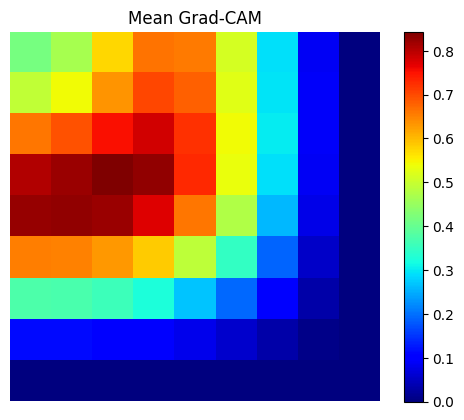

Mean CAM matrix shape: torch.Size([9, 9])


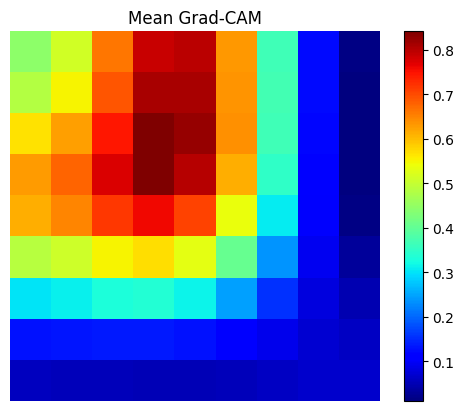

Mean CAM matrix shape: torch.Size([9, 9])


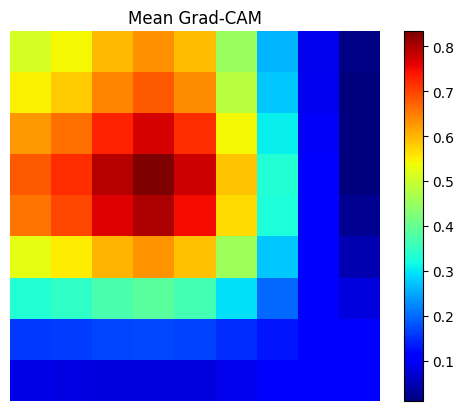

Mean CAM matrix shape: torch.Size([9, 9])


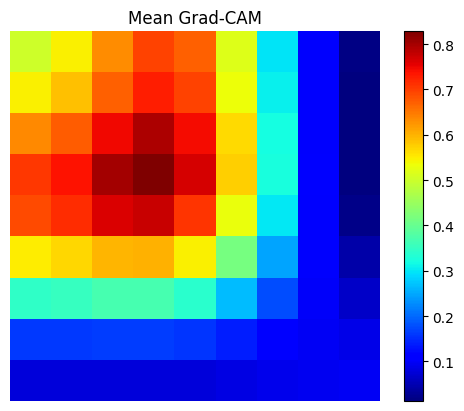

Mean CAM matrix shape: torch.Size([9, 9])


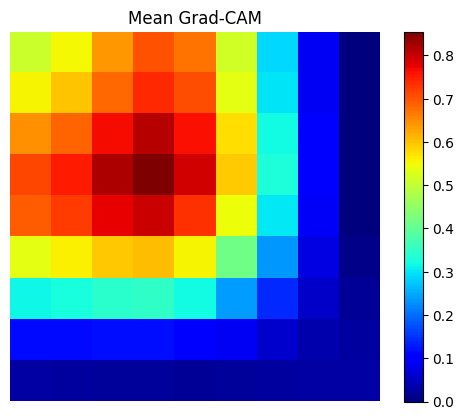

Mean CAM matrix shape: torch.Size([9, 9])


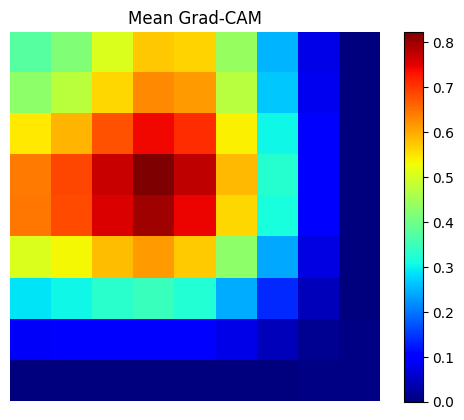

Mean CAM matrix shape: torch.Size([9, 9])


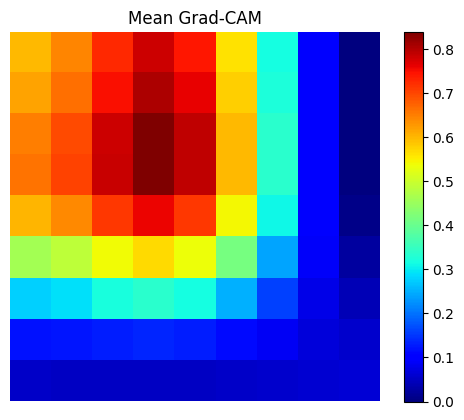

Mean CAM matrix shape: torch.Size([9, 9])


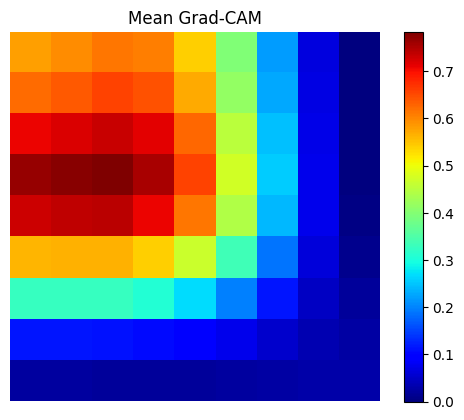

In [10]:
import torch
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from swin_CAM import SwinTransformer  
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# 假设目标层输出为 (batch, 36, 1536)，即 6×6 patch，1536 维特征
def reshape_transform(tensor, time=4, height=3, width=3):
    # 输入形状: (B, 36, 1536)
    B, seq_len, C = tensor.size()

    result = tensor.reshape(B, time, height, width, C)
    # result = torch.mean(result, dim=1)
    result = result.permute(0, 4, 1, 2, 3)  # (B, C, H, W)
    return result

# 加载模型
model = SwinTransformer(patch_size=(8,1,1),
                        depths=(2, 2, 4),
                        num_heads=(2,2,3),
                        window_size=(4,3,3)
                        )
model_path = "swin_fold_4.pth"  # 指定模型文件路径
model.load_state_dict(torch.load(model_path),strict=False)
model.eval()
target_layers = [model.layers[-1].blocks[-1].norm2]  # 替换为你的实际目标层

# 是否使用GPU
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

# 示例 EEG 输入 (batch, 1, 128, 9, 9)
# eeg_input = torch.randn(2, 1, 128, 9, 9)  # 假设 batch size 为 2

test_loader = DataLoader(dataset,
                        batch_size=32,
                        shuffle=False)

# 只处理第一个 batch
for eeg_input, label in test_loader:
    if use_cuda:
        eeg_input = eeg_input.cuda()

    result = model(eeg_input)

    # 初始化 GradCAM
    cam = GradCAM(model=model,
                  target_layers=target_layers,
                  reshape_transform=reshape_transform)

    # 可选：设定类别目标（None 为默认分类）
    targets = None

    # 生成 CAM
    grayscale_cam = cam(input_tensor=eeg_input, targets=targets)  # shape: (batch, H, W)

    # 转为 tensor 方便处理
    cam_tensor = torch.tensor(grayscale_cam)  # shape: (batch_size, H, W)

    # 取 CAM 的 batch 均值
    cam_mean = torch.mean(cam_tensor, dim=0)  # shape: (H, W)

    print("Mean CAM matrix shape:", cam_mean.shape)
    # print("Mean CAM values:\n", cam_mean)

    # 可视化（可选）
    plt.imshow(cam_mean.cpu().numpy(), cmap='jet')
    plt.title("Mean Grad-CAM")
    plt.axis("off")
    plt.colorbar()
    plt.show()


In [12]:
score = np.round(grayscale_cam[0],3)
print(score)

[[0.747 0.806 0.92  1.    0.953 0.727 0.408 0.125 0.002]
 [0.747 0.801 0.907 0.974 0.924 0.699 0.391 0.118 0.   ]
 [0.739 0.782 0.86  0.903 0.843 0.631 0.351 0.106 0.   ]
 [0.706 0.734 0.78  0.796 0.725 0.542 0.304 0.1   0.014]
 [0.631 0.645 0.664 0.656 0.588 0.443 0.265 0.114 0.05 ]
 [0.509 0.514 0.516 0.498 0.446 0.353 0.246 0.154 0.118]
 [0.372 0.37  0.363 0.348 0.32  0.282 0.24  0.208 0.194]
 [0.26  0.256 0.246 0.235 0.23  0.234 0.242 0.253 0.258]
 [0.213 0.208 0.197 0.19  0.196 0.216 0.246 0.272 0.284]]
